In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

     |████████████████████████████████| 2.0MB 7.7MB/s 
     |████████████████████████████████| 1.2MB 36.5MB/s 
     |████████████████████████████████| 870kB 44.1MB/s 
     |████████████████████████████████| 3.2MB 48.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=80c67144c25f027e1ae5f50182af749e00088a0f1bcc0d6a9b6ade86103b3f58
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import transformers
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_dev.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [ ]:
data_dir = "./gdrive/MyDrive/FYP/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.bert = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    for param in self.bert.parameters():
      param.requires_grad = False
    
    self.resnet = torchvision.models.resnet18(pretrained=True)
    for param in self.resnet.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.bert.config.hidden_size + 1000)

    self.linear1 = nn.Linear(self.bert.config.hidden_size + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input_ids, attention_mask, tweet_img):
    text_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    image_output = self.resnet(tweet_img)
    merged_output = torch.cat((torch.mean(text_output[0], 1), image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.sigmoid(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [7]:
BATCH_SIZE = 512
MAX_LEN = 150

tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

In [13]:
checkpoint = torch.load("./gdrive/MyDrive/FYP/XlnetResNet-checkpoint.t7")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']

print(start_epoch)
print(best_accuracy)

40
tensor(0.8493, device='cuda:0', dtype=torch.float64)


In [9]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/FYP/BertResNet-checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']
# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/FYP/XlnetResNet-checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6494963765144348 accuracy 0.5949380272888241
Val   loss 0.52590411901474 accuracy 0.7069294342021615

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.5012179456259075 accuracy 0.7638787626288928
Val   loss 0.4709901064634323 accuracy 0.7991099809281628

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4144526751417863 accuracy 0.8229351109259452
Val   loss 0.41846640408039093 accuracy 0.8124602670057216

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.36477417538040563 accuracy 0.8373086136860743
Val   loss 0.42301981151103973 accuracy 0.821360457724094

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.33993052965716314 accuracy 0.855327570044787
Val   loss 0.43029023706912994 accuracy 0.8226319135410045

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3298443273494118 accuracy 0.860222893448599
Val   loss 0.4247180446982384 accuracy 0.821360457724094

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.31463960597389623 accuracy 0.8672013331944589
Val   loss 0.40788542479276657 accuracy 0.8302606484424666

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.31025151516261856 accuracy 0.8658473075721279
Val   loss 0.40502508729696274 accuracy 0.8366179275270185

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3036999561284718 accuracy 0.8687636704509947
Val   loss 0.39875128120183945 accuracy 0.8372536554354736

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.29909672078333405 accuracy 0.8705343193417352
Val   loss 0.3981952369213104 accuracy 0.8385251112523839

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.29179458869130986 accuracy 0.874804707842933
Val   loss 0.40281815081834793 accuracy 0.8334392879847425

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.28565599886994614 accuracy 0.8799083428809499
Val   loss 0.3966451585292816 accuracy 0.8429752066115702

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2831450198826037 accuracy 0.8787626288928236
Val   loss 0.39020347595214844 accuracy 0.8442466624284807

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.27685616832030446 accuracy 0.8839704197479429
Val   loss 0.3862042650580406 accuracy 0.8417037507946599

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.27627319881790563 accuracy 0.8837621081137381
Val   loss 0.38784849643707275 accuracy 0.8423394787031151

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.27066039568499517 accuracy 0.8839704197479429
Val   loss 0.3832852989435196 accuracy 0.8423394787031151

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2726866555841346 accuracy 0.8844911988334548
Val   loss 0.38558994978666306 accuracy 0.8429752066115702

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26906082504674006 accuracy 0.8883449640662431
Val   loss 0.38092635571956635 accuracy 0.8436109345200254

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26692169198864385 accuracy 0.8862618477241954
Val   loss 0.36913179606199265 accuracy 0.8474253019707565

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26113777411611455 accuracy 0.8900114571398813
Val   loss 0.3723835200071335 accuracy 0.8480610298792117

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2600213963734476 accuracy 0.8913654827622123
Val   loss 0.3783477619290352 accuracy 0.845518118245391

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25438765789333145 accuracy 0.8914696385793146
Val   loss 0.38107891380786896 accuracy 0.8461538461538461

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2546902863602889 accuracy 0.8951150921778981
Val   loss 0.38410665839910507 accuracy 0.845518118245391

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25082042185883774 accuracy 0.8970940527028434
Val   loss 0.37783437222242355 accuracy 0.8429752066115702

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2539988764022526 accuracy 0.894802624726591
Val   loss 0.38550063967704773 accuracy 0.8436109345200254

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2426950962919938 accuracy 0.9017810644724508
Val   loss 0.38123663514852524 accuracy 0.8436109345200254

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.25346447448981435 accuracy 0.8928236642016456
Val   loss 0.3798246830701828 accuracy 0.8436109345200254

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2518510692997983 accuracy 0.8963649619831268
Val   loss 0.3791632577776909 accuracy 0.8442466624284807

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2418305113127357 accuracy 0.9019893761066555
Val   loss 0.375741183757782 accuracy 0.845518118245391

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24303071200847626 accuracy 0.896989896885741
Val   loss 0.3774314969778061 accuracy 0.8442466624284807

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24398194253444672 accuracy 0.8981356108738673
Val   loss 0.3814033642411232 accuracy 0.8436109345200254

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2379953445572602 accuracy 0.9006353504843245
Val   loss 0.37807507812976837 accuracy 0.8436109345200254

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23944096031941867 accuracy 0.8978231434225601
Val   loss 0.3775141313672066 accuracy 0.8429752066115702

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2424737960100174 accuracy 0.899697948130403
Val   loss 0.3724463954567909 accuracy 0.8467895740623014

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24240495107675852 accuracy 0.9008436621185293
Val   loss 0.3700687065720558 accuracy 0.8461538461538461

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23825732187220924 accuracy 0.9025101551921675
Val   loss 0.3718583211302757 accuracy 0.845518118245391

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23534143676883296 accuracy 0.904280804082908
Val   loss 0.3696829155087471 accuracy 0.8480610298792117

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24073973062791323 accuracy 0.901051973752734
Val   loss 0.37100545316934586 accuracy 0.8461538461538461

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2348968731729608 accuracy 0.903760024997396
Val   loss 0.369330994784832 accuracy 0.8486967577876668

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23158887420829974 accuracy 0.9025101551921675
Val   loss 0.3700249716639519 accuracy 0.8493324856961221

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2379052239029031 accuracy 0.9014685970211436
Val   loss 0.37164975702762604 accuracy 0.8467895740623014

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2290939814166019 accuracy 0.9062597646078533
Val   loss 0.37019094824790955 accuracy 0.8474253019707565

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2329754374529186 accuracy 0.905634829705239
Val   loss 0.36855463683605194 accuracy 0.8486967577876668

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23104076244329153 accuracy 0.9062597646078533
Val   loss 0.37172386795282364 accuracy 0.8467895740623014

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23116246022676168 accuracy 0.9053223622539318
Val   loss 0.3710905984044075 accuracy 0.8474253019707565

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23557474424964503 accuracy 0.9021976877408603
Val   loss 0.37185677886009216 accuracy 0.8461538461538461

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23333551930753807 accuracy 0.9030309342776793
Val   loss 0.3727661147713661 accuracy 0.8474253019707565

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23245044680018173 accuracy 0.9070930111446724
Val   loss 0.37109018862247467 accuracy 0.8474253019707565

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22934416328605853 accuracy 0.9040724924487032
Val   loss 0.3717152401804924 accuracy 0.8480610298792117

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2266901715805656 accuracy 0.9112592438287678
Val   loss 0.3727584779262543 accuracy 0.8480610298792117



In [10]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/FYP/XlnetResNet-checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

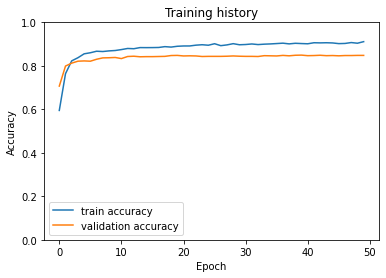

In [11]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [14]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative'], digits=4))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


                 precision    recall  f1-score   support

Not Informative     0.8858    0.6310    0.7370       504
    Informative     0.8417    0.9602    0.8971      1030

       accuracy                         0.8520      1534
      macro avg     0.8637    0.7956    0.8170      1534
   weighted avg     0.8562    0.8520    0.8445      1534

